# Task-4 Image Reconstruction using Matrix Factorisation

# Question 4.2

Q2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.

### Importing Required Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Number of GPUs:', torch.cuda.device_count())

Using device: cpu
Number of GPUs: 0


In [7]:
# Setting the seed for Python, NumPy, and PyTorch (both CPU and GPU)
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using CUDA
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disables the auto-tuner that finds the best algorithm

set_seed(42)

In [8]:
img = torchvision.io.read_image('/content/iitgn.jpg')
print(img.shape)

torch.Size([3, 640, 1280])


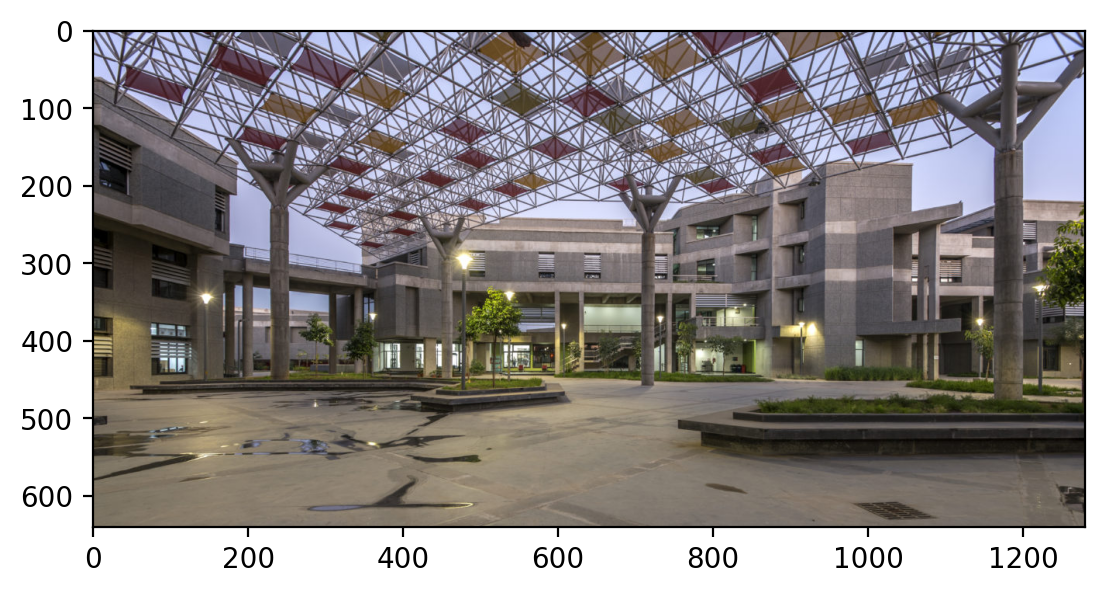

In [9]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

### Convert image to grayscale

torch.Size([640, 1280])


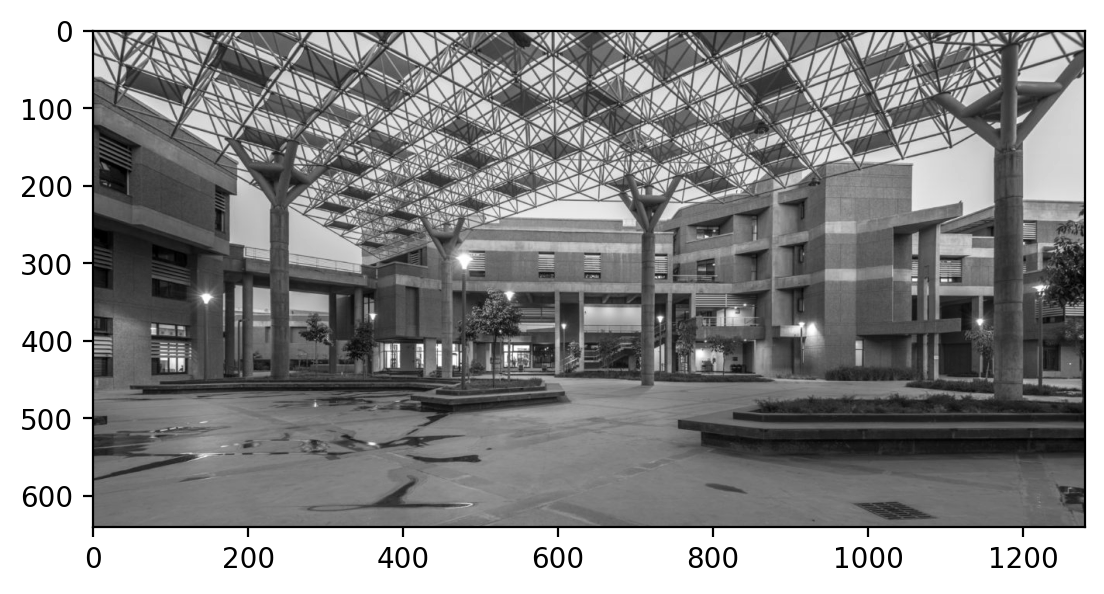

In [10]:
# Make grayscale
gray_img = torch.tensor(img, dtype=torch.float)
gray_img = gray_img.mean(dim=0, keepdim=False)
print(gray_img.shape)
plt.imshow(gray_img, cmap='gray')

In [11]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(gray_img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [12]:
img_scaled = scaler_img.transform(gray_img.reshape(-1, 1)).reshape(gray_img.shape)
img_scaled = torch.tensor(img_scaled, dtype=torch.float32)

img_scaled = img_scaled.to(device)
print("Shape of the scaled image:", img_scaled.shape)
img_scaled

Shape of the scaled image: torch.Size([640, 1280])


tensor([[0.8771, 0.8366, 0.8405,  ..., 0.8392, 0.8654, 0.8601],
        [0.8693, 0.8588, 0.8484,  ..., 0.8536, 0.8575, 0.8510],
        [0.8314, 0.8444, 0.8837,  ..., 0.8549, 0.8536, 0.8444],
        ...,
        [0.4327, 0.4327, 0.4327,  ..., 0.4340, 0.4379, 0.4418],
        [0.4327, 0.4327, 0.4327,  ..., 0.4379, 0.4340, 0.4340],
        [0.4327, 0.4288, 0.4288,  ..., 0.4379, 0.4340, 0.4301]])

### Crop the image

torch.Size([300, 300])


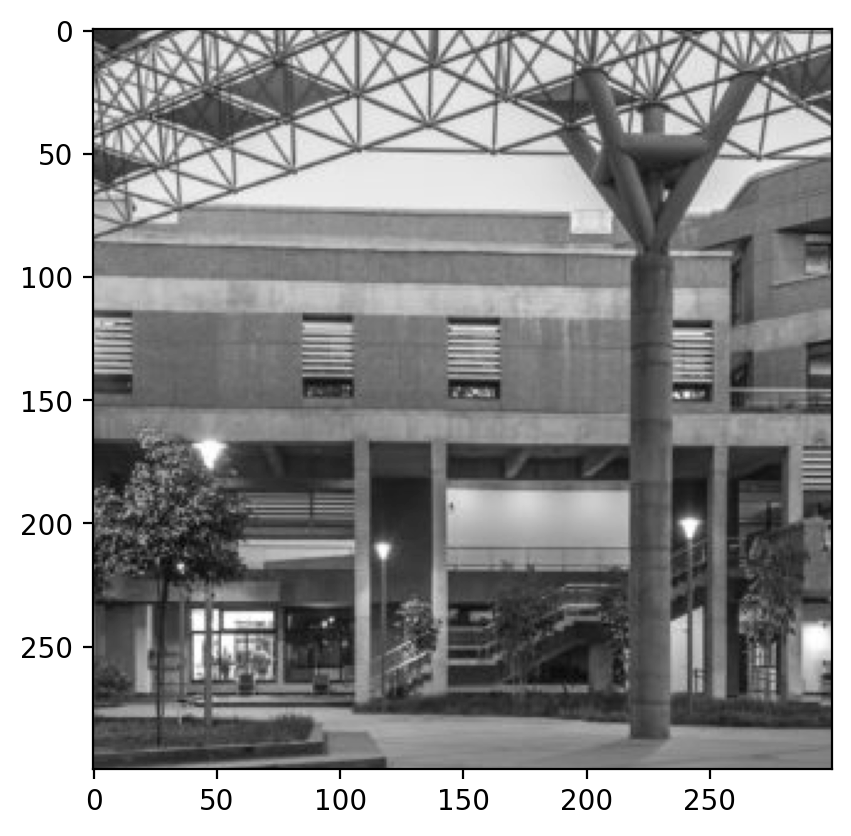

In [13]:
crop = torchvision.transforms.CenterCrop(300)(img_scaled)
print(crop.shape)
plt.imshow(crop.cpu(), cmap='gray')
crop = crop.to(device)

### Masking a square patch on the image

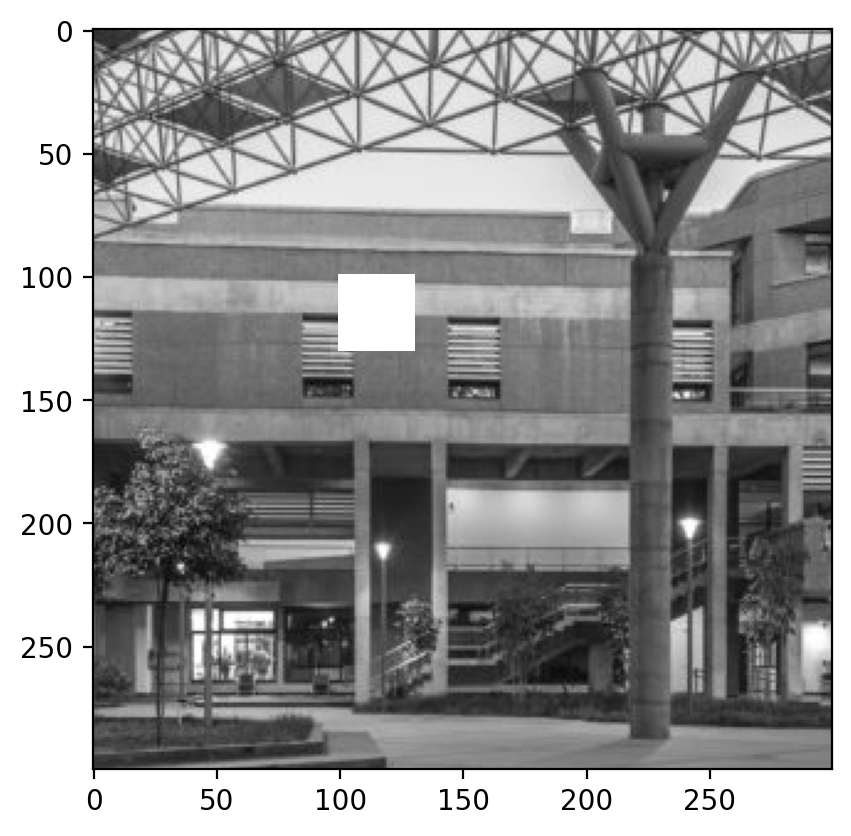

In [14]:
height, width = crop.shape

patch_size = 30

if patch_size > height or patch_size > width:
    raise ValueError("Patch size must be smaller than the dimensions of the image.")

margin = 30  # margin to avoid the corners
# top_left_x = np.random.randint(margin, height - patch_size - margin)
# top_left_y = np.random.randint(margin, width - patch_size - margin)
top_left_x = 100
top_left_y = 100

# Remove the patch from the image
masked_img = crop.clone()
masked_img[top_left_x:top_left_x + patch_size, top_left_y:top_left_y + patch_size] = float('nan')

plt.imshow(masked_img.cpu(), cmap='gray')


### Defining Functions

In [15]:
def plot_results(original_img, masked_img, reconstructed_img, rank, mask_value):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Image Reconstruction with Features={rank} and Mask={mask_value}x{mask_value} patch")
    # Original image
    axes[0].imshow(original_img.cpu(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    # Masked image
    axes[1].imshow(masked_img.cpu(), cmap='gray')
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    # Reconstructed image
    axes[2].imshow(reconstructed_img, cmap='gray')
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    plt.show()

def calculate_rmse_psnr(original_img, reconstructed_img):
    """
    Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

    Args:
        original_img (torch.Tensor): The original image tensor.
        reconstructed_img (torch.Tensor): The reconstructed image tensor.

    Returns:
        rmse (float): The Root Mean Squared Error (RMSE).
        psnr (float): The Peak Signal-to-Noise Ratio (PSNR).
    """
    # if original_img.device != reconstructed_img.device:
    #     original_img = original_img.to(reconstructed_img.device)
    original_img = torch.tensor(original_img) if not isinstance(original_img, torch.Tensor) else original_img
    reconstructed_img = torch.tensor(reconstructed_img) if not isinstance(reconstructed_img, torch.Tensor) else reconstructed_img

    mse = F.mse_loss(reconstructed_img, original_img)
    rmse = torch.sqrt(mse)
    max_pixel_value = 1.0
    psnr = 20 * torch.log10(max_pixel_value / rmse)
    print(f"RMSE: {rmse.item()}")
    print(f"PSNR: {psnr.item()}")
    return rmse.item(), psnr.item()


## Reconstruction using Random Fourier Features

In [16]:
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

def image_reconstruction_rff(img, patch_size=30, top_left_x=0, top_left_y=0, n_components=20000, sigma=1.0):
    """
    Reconstruct an image with a missing patch using Random Fourier Features (RFF) and Linear Regression.

    Args:
        img (torch.Tensor): The image tensor of shape (height, width).
        patch_size (int): The size of the patch to mask (default is 30x30).
        top_left_x (int): The top-left x-coordinate of the patch (default is 0).
        top_left_y (int): The top-left y-coordinate of the patch (default is 0).
        n_components (int): The number of components for the RFF (default is 20000).
        sigma (float): The sigma parameter for the RBF kernel (default is 1.0).

    Returns:
        reconstructed_image (torch.Tensor): The reconstructed image with the missing patch filled in.
        masked_img (torch.Tensor): The image with the patch replaced by NaNs.
    """
    # Remove patch from the image
    masked_img = img.clone()
    masked_img[top_left_x:top_left_x + patch_size, top_left_y:top_left_y + patch_size] = float('nan')

    # Convert the channel to NumPy if it's a PyTorch tensor
    maskedd_img_np = masked_img.cpu().numpy() if isinstance(masked_img, torch.Tensor) else masked_img

    height, width = maskedd_img_np.shape
    x_coordinates, y_coordinates = np.meshgrid(np.arange(width), np.arange(height))
    coordinates = np.stack([x_coordinates.ravel(), y_coordinates.ravel()], axis=-1)

    # Mask the known and missing pixels
    mask_known = ~np.isnan(maskedd_img_np)
    mask_missing = np.isnan(maskedd_img_np)

    # Get the known pixel coordinates and their corresponding values
    known_coordinates = coordinates[mask_known.ravel()]
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(known_coordinates)
    known_coordinates_scaled = scaler.transform(known_coordinates)
    known_values = maskedd_img_np[mask_known]
    print("Shape of known coordinates:", known_coordinates_scaled.shape)
    print("Shape of known values:", known_values.shape)

    # Apply Random Fourier Features (RFF) to the known coordinates
    rff = RBFSampler(n_components=n_components, gamma=1/(2 * sigma**2))
    X_rff = rff.fit_transform(known_coordinates_scaled)
    print("Shape of the RFF matrix:", X_rff.shape)

    # Fit a Ridge regression model to the known values
    ridge = Ridge(alpha=1.0, tol=1e-6)
    ridge.fit(X_rff, known_values)

    # Predict the missing values using the trained model
    missing_coordinates = coordinates[mask_missing.ravel()]
    missing_coordinates_scaled = scaler.transform(missing_coordinates)
    X_missing = rff.transform(missing_coordinates_scaled)
    predicted_values = ridge.predict(X_missing)

    # Reconstruct the original image by filling in the missing values
    reconstructed_image = np.copy(maskedd_img_np)
    reconstructed_image[mask_missing] = torch.tensor(predicted_values, dtype=torch.float32, device=img.device)

    return reconstructed_image, masked_img


In [17]:
reconstructed_image, masked_img = image_reconstruction_rff(crop, patch_size=30, top_left_x=100, top_left_y=100, n_components=40000, sigma=0.008)

Shape of known coordinates: (89100, 2)
Shape of known values: (89100,)
Shape of the RFF matrix: (89100, 40000)


In [18]:
print("Reconstructed image shape:", reconstructed_image.shape)

Reconstructed image shape: (300, 300)


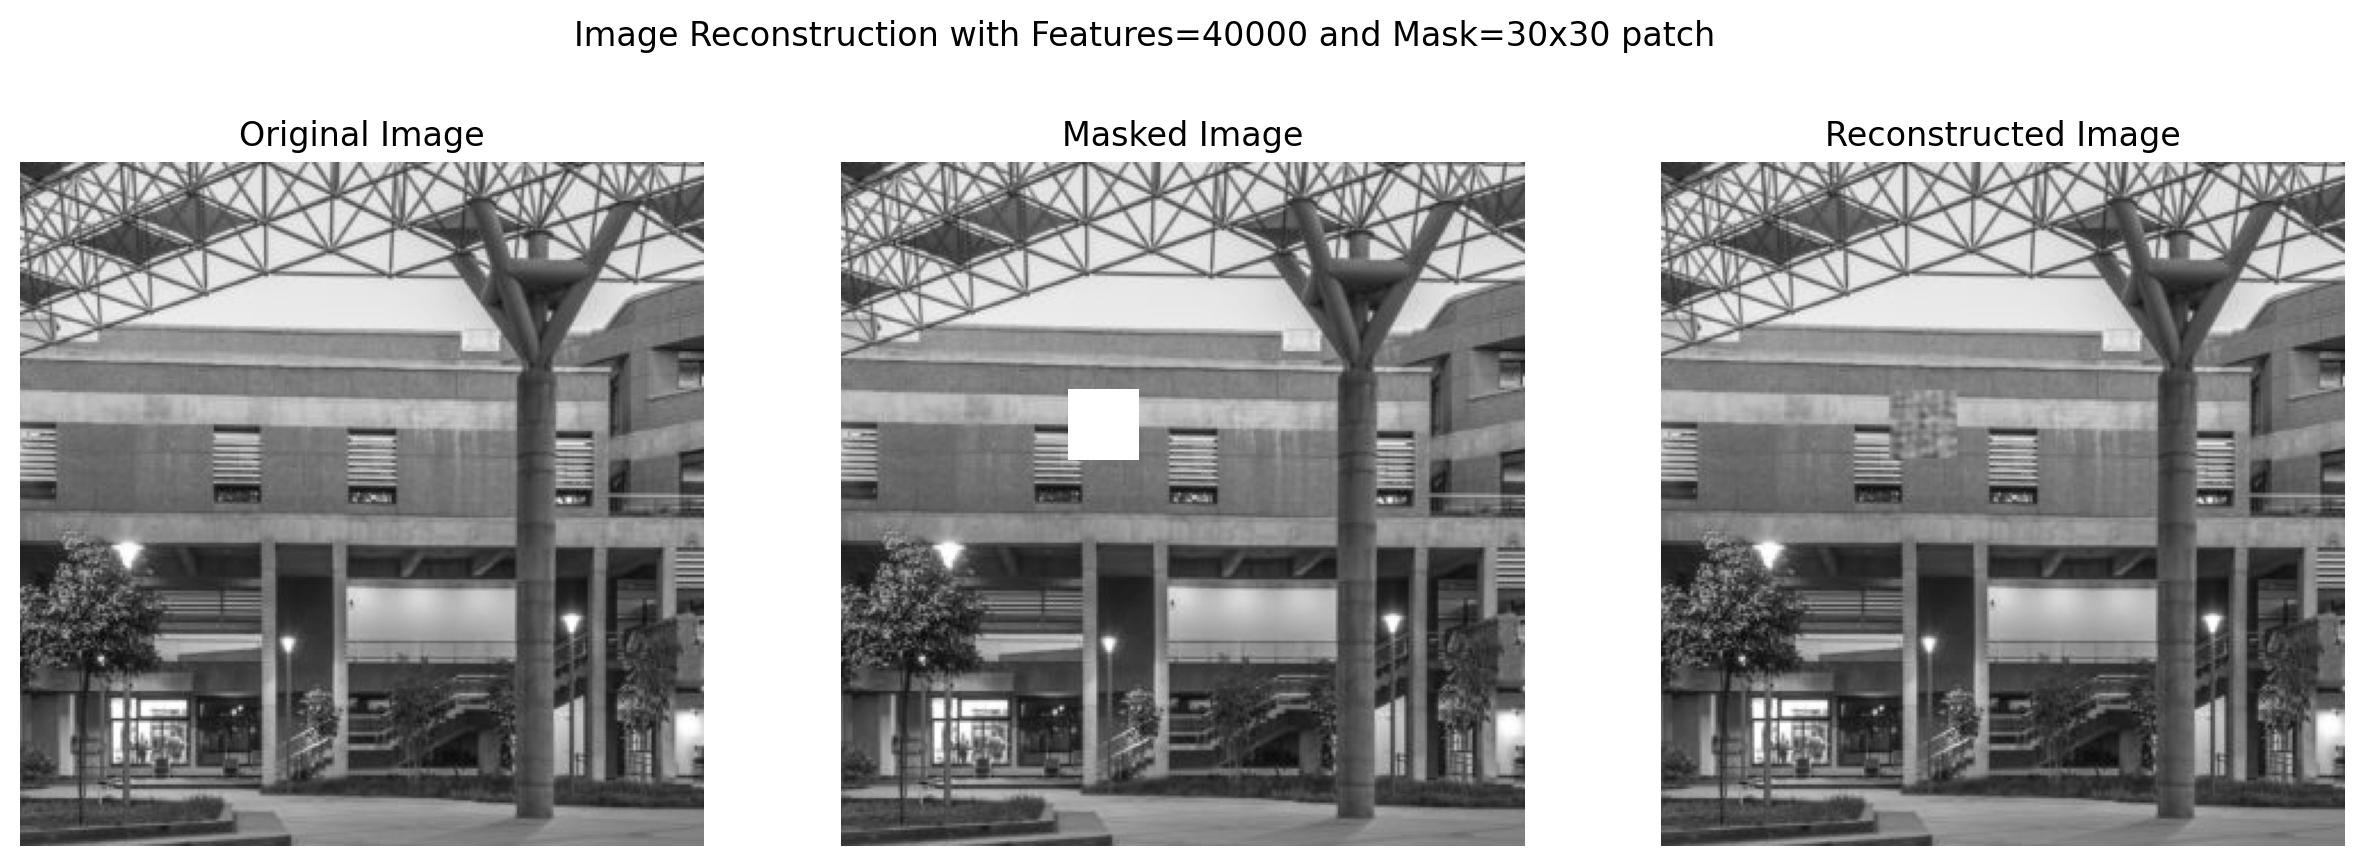

RMSE: 0.014734148979187012
PSNR: 36.63349914550781


(0.014734148979187012, 36.63349914550781)

In [19]:
plot_results(crop, masked_img, reconstructed_image, rank=40000, mask_value=30)
calculate_rmse_psnr(crop, reconstructed_image)